# January, 12th 2020

**Motivation**: Simulation to understand Partial Least Squares (PLS) and Canonical Correlation Analysis (CCA).<br>
**Result**: These methods detect the shared, low-dimensional latent signal in simulated data.

In [1]:
# HIDE CODE


# imports
import os
import sys
import h5py
import pickle
import random
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import rcca
from sklearn.cross_decomposition import PLSCanonical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from simulation.simulation import *

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# load data
# dirs_dict = get_dirs()

## Simulation

In this seciton I will briefly describe details of the simulation.

### Random projection to higher dim space

### PLS

In [2]:
n_samples = int(1e6)
dim_x, dim_y = 8, 8
sigma = 0.5

sim = create_pls_simulation(
    n_samples=n_samples,
    three_d=False,
    angle_spacing=1.0,
    magnitude_range=None,
    dim_x=dim_x,
    dim_y=dim_y,
    sigma=sigma,
    orthogonal=False,
    normal=True,
    seed=SEED,
)

pls = PLSCanonical(
    n_components=3,
    scale=True,
    algorithm='svd',
    max_iter=int(1e9),
    tol=1e-15,
).fit(sim['x_train'], sim['y_train'])

Simulation info:

num samples:	1e+06,
noise sigma:	0.5,
dim Z:	2,
dim X:	8,
dim Y:	8





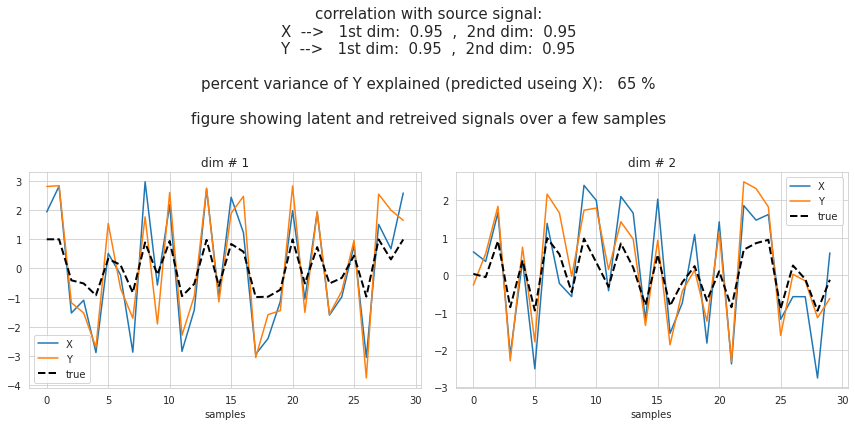

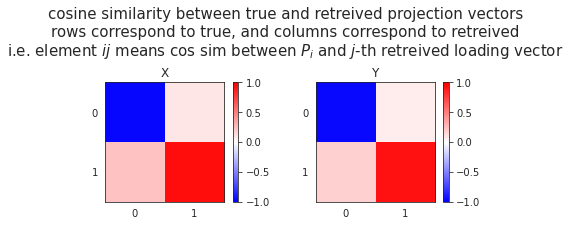

matrix values:

X:
[[-0.97616372  0.09995446]
 [ 0.23588685  0.95087454]]

Y:
[[-0.96326662  0.07617585]
 [ 0.18448362  0.92466731]]



Angle between true projection vectors:
X:  97 degrees,   Y:  98 degrees

Angle between retreived loading vectors:
X:  89 degrees,   Y:  92 degrees




In [3]:
results = visualize_pls_results(pls, sim, verbose=True)

In [4]:
results

{'latent_corr': 0.951,
 'proj_cos_sim': 0.954,
 'pred_r2': 64.922,
 'pred_r': 0.813}

### SVD

In [5]:
from scipy.linalg import svd

u, s, vh = svd(sim['x_train'], full_matrices=False)
u.shape, s.shape, vh.shape

((1000000, 8), (8,), (8, 8))

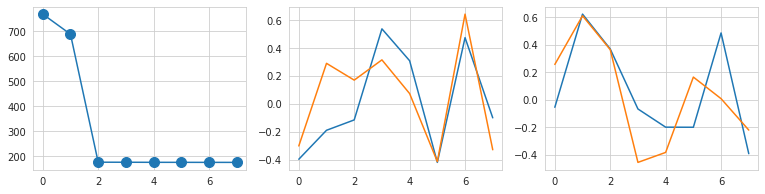

In [6]:
sns.set_style('whitegrid')
plt.figure(figsize=(13, 3))

plt.subplot(131)
plt.plot(s, marker='o', markersize=10)

plt.subplot(132)
plt.plot(-sim['P'][:, 0])
plt.plot(vh[0])

plt.subplot(133)
plt.plot(sim['P'][:, 1])
plt.plot(vh[1])
plt.show()

In [7]:
pearsonr(u[:, 0], -sim['z_train'][:, 0]), pearsonr(u[:, 1], sim['z_train'][:, 1])

((0.6879898229731866, 0.0), (0.6837250794672463, 0.0))

In [8]:
pearsonr(u[:, 1], -sim['z_train'][:, 0]), pearsonr(u[:, 0], sim['z_train'][:, 1])

((-0.6834551823859355, 0.0), (0.6877400082876172, 0.0))

In [9]:
pearsonr(vh[0], -sim['P'][:, 0]), pearsonr(vh[1], sim['P'][:, 1])

((0.7517628918619289, 0.03147563302548768),
 (0.6577763966732155, 0.07624254495314915))

### comparison

In [10]:
df, args = run_pls_loop(
    n_seeds=30,
    equal_dims=True,
    sample_sizes=[10**i for i in range(2, 7)],
    dims_x=8,
    three_d=False,
    orthogonal=False,
    normal=True,
    sigmas=[0.0, 0.2, 0.5],
)

In [11]:
args['seeds'], args['sample_sizes'], args['sigmas']

([1,
  2,
  4,
  8,
  16,
  32,
  64,
  128,
  256,
  512,
  1024,
  2048,
  4096,
  8192,
  16384,
  32768,
  65536,
  131072,
  262144,
  524288,
  1048576,
  2097152,
  4194304,
  8388608,
  16777216,
  33554432,
  67108864,
  134217728,
  268435456,
  536870912],
 [100, 1000, 10000, 100000, 1000000],
 [0.0, 0.2, 0.5])

In [70]:
def find_corr(true, pred):
    n = true.shape[1]
    m = pred.shape[1]
    
    corrs = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            corrs[i, j] = pearsonr(true[:, i], pred[:, j])[0]
            
    idxs = np.argsort(np.abs(corr_proj), axis=0)[::-1][:, 0]
    mean_corr = [abs(corrs[i, idxs[i]]) for i in range(n)]
    mean_corr = np.mean(mean_corr)
            
    return corrs, mean_corr

In [71]:
corr_proj, avg_corr_proj = find_corr(sim['P'], vh.T)
corr_latent, avg_corr_latent = find_corr(sim['z_train'], u)

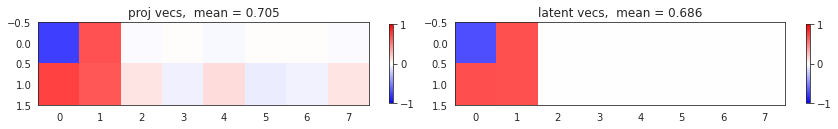

In [72]:
sns.set_style('white')
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(corr_proj, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(shrink=0.3)
plt.title('proj vecs,  mean = {:.3f}'.format(avg_corr_proj))

plt.subplot(122)
plt.imshow(corr_latent, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(shrink=0.3)
plt.title('latent vecs,  mean = {:.3f}'.format(avg_corr_latent))

plt.tight_layout()
plt.show()

In [48]:
corr_proj

array([[-0.75176289,  0.67451306, -0.01890765,  0.01019979, -0.02384396,
         0.01365751,  0.00871914, -0.01859176],
       [ 0.73974613,  0.6577764 ,  0.10536968, -0.05486639,  0.13636714,
        -0.07570445, -0.04834066,  0.10613632]])

In [52]:
idxs = np.argsort(np.abs(corr_proj), axis=0)[::-1]
idxs

array([[0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0]])

In [54]:
idxs[1]

array([1, 1, 0, 0, 0, 0, 0, 0])

In [55]:
corr_proj[1, 1]

0.6577763966732155

In [56]:
corr_proj[0, 0]

-0.7517628918619289

In [57]:
corr_proj[0, 1]

0.6745130615114305

In [ ]:
sim = create_pls_simulation(
    n_samples=n_samples,
    three_d=False,
    angle_spacing=1.0,
    magnitude_range=None,
    dim_x=dim_x,
    dim_y=dim_y,
    sigma=sigma,
    orthogonal=False,
    normal=True,
    seed=SEED,
)

### LOOP

### Effect of projection dimensionality

In [5]:
from tqdm.notebook import tqdm

In [6]:
df, args = run_pls_loop(
    sample_sizes=int(1e3),
    dims_x=np.arange(4, 121, 2).astype(int),
    dims_y=np.arange(4, 181, 2).astype(int),
    three_d=False,
    orthogonal=False,
    normal=True,
    sigmas=0.2,
)

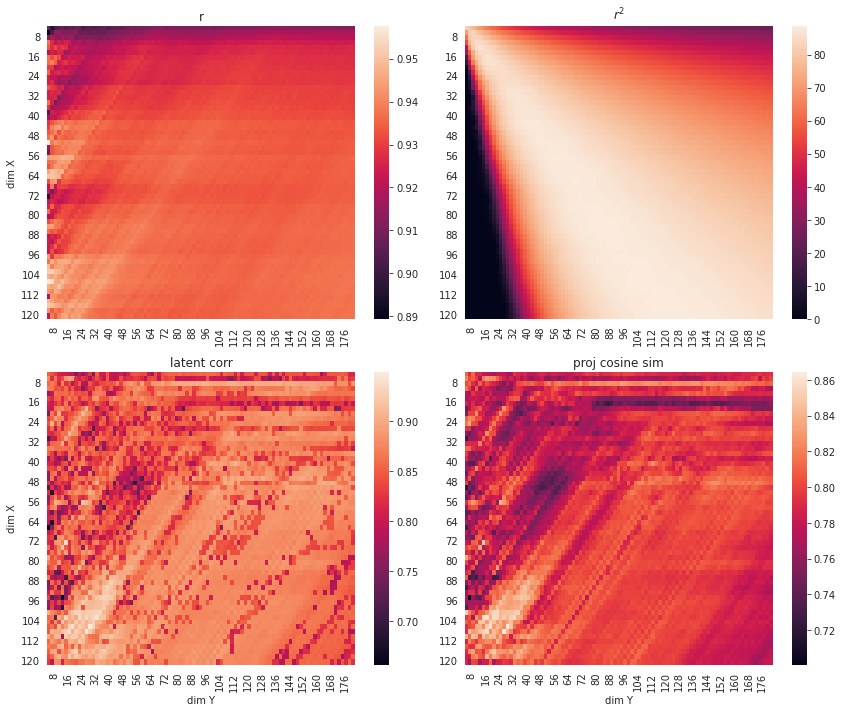

In [7]:
latent_corr = np.zeros((len(args['dims_x']), len(args['dims_y'])))
proj_cos_sim = np.zeros((len(args['dims_x']), len(args['dims_y'])))
r2 = np.zeros((len(args['dims_x']), len(args['dims_y'])))
r = np.zeros((len(args['dims_x']), len(args['dims_y'])))

for i, dim_x in enumerate(args['dims_x']):
    for j, dim_y in enumerate(args['dims_y']):
        selected_df = df.loc[(df.dim_x == dim_x) & (df.dim_y == dim_y)]
        r[i, j] = selected_df.pred_r.mean()
        r2[i, j] = selected_df.pred_r2.mean()
        latent_corr[i, j] = selected_df.latent_corr.mean()
        proj_cos_sim[i, j] = selected_df.proj_cos_sim.mean()
        
fig, axes = plt.subplots(2, 2, figsize=(12, 10))#, sharex='all', sharey='all')

sns.heatmap(r, ax=axes[0, 0])
sns.heatmap(r2, ax=axes[0, 1])
sns.heatmap(latent_corr, ax=axes[1, 0])
sns.heatmap(proj_cos_sim, ax=axes[1, 1])

axes[0, 0].set_title('r')
axes[0, 1].set_title('$r^2$')
axes[1, 0].set_title('latent corr')
axes[1, 1].set_title('proj cosine sim')

axes[0, 0].set_ylabel('dim X')
axes[1, 0].set_ylabel('dim X')
axes[1, 0].set_xlabel('dim Y')
axes[1, 1].set_xlabel('dim Y')

xticks = [i for i, item in enumerate(args['dims_y']) if item % 8 == 0]
yticks = [i for i, item in enumerate(args['dims_x']) if item % 8 == 0]

for i in range(2):
    for j in range(2):
        axes[i, j].set_xticks(xticks)
        axes[i, j].set_yticks(yticks)
        axes[i, j].set_xticklabels(np.array(args['dims_y'])[xticks])
        axes[i, j].set_yticklabels(np.array(args['dims_x'])[yticks])

fig.tight_layout()
plt.show()

In [18]:
df, args = run_pls_loop(
    n_seeds=30,
    equal_dims=True,
    sample_sizes=int(1e2),
    dims_x=list(np.arange(3, 71, 1).astype(int)),
    three_d=False,
    orthogonal=[False, True],
    normal=True,
    sigmas=[0.0, 0.25, 0.5],
)

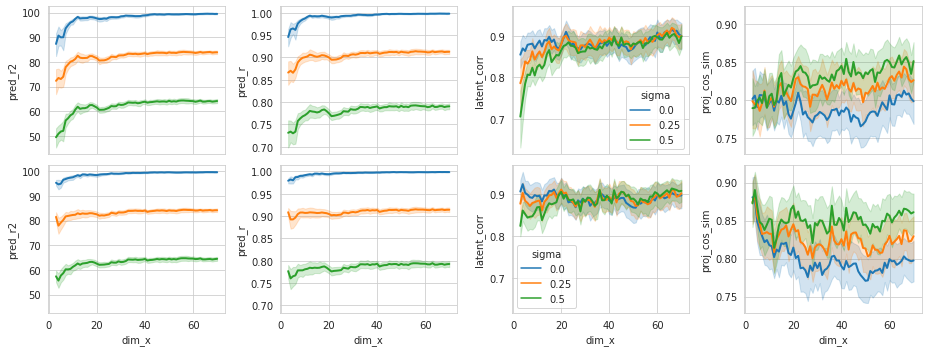

In [22]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 4, figsize=(13, 5), sharex='all', sharey='col')
palette = sns.color_palette(palette=None, n_colors=3)

for i in range(2):
    selected_df = df.loc[df.orthogonal == i]

    sns.lineplot(x='dim_x', y='pred_r2', data=selected_df, hue='sigma', style='sigma',
                 legend=False, dashes=False, lw=2, palette=palette, ax=axes[i, 0])
    sns.lineplot(x='dim_x', y='pred_r', data=selected_df, hue='sigma', style='sigma',
                 legend=False, dashes=False, lw=2, palette=palette, ax=axes[i, 1])
    sns.lineplot(x='dim_x', y='latent_corr', data=selected_df, hue='sigma', style='sigma',
                 legend=True, dashes=False, lw=2, palette=palette, ax=axes[i, 2])
    sns.lineplot(x='dim_x', y='proj_cos_sim', data=selected_df, hue='sigma', style='sigma',
                 legend=False, dashes=False, lw=2, palette=palette, ax=axes[i, 3])

plt.tight_layout()
plt.show()

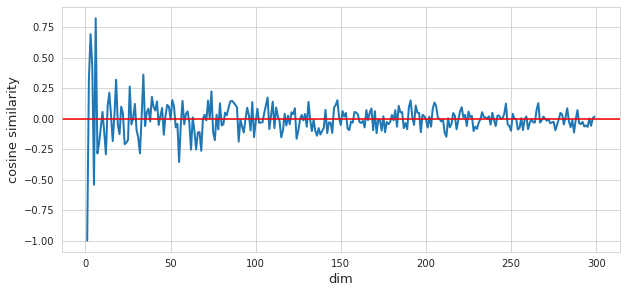

In [23]:
result = []
for d in range(300):
    result.append(cos_similarity(np.random.randn(d), np.random.randn(d)))

plt.figure(figsize=(10, 4.5))
plt.plot(result, lw=2)
plt.axhline(0, color='r')
plt.xlabel('dim', fontsize=13)
plt.ylabel('cosine similarity', fontsize=13)
plt.show()

### Effect of num samples

In [32]:
df, args = run_pls_loop(
    sample_sizes=[10, 50, 100, 150, 200, 300],
    equal_dims=True,
    dims_x=[4, 16, 64],
    three_d=False,
    orthogonal=False,
    normal=True,
    sigmas=0.5,
    n_seeds=30,
)

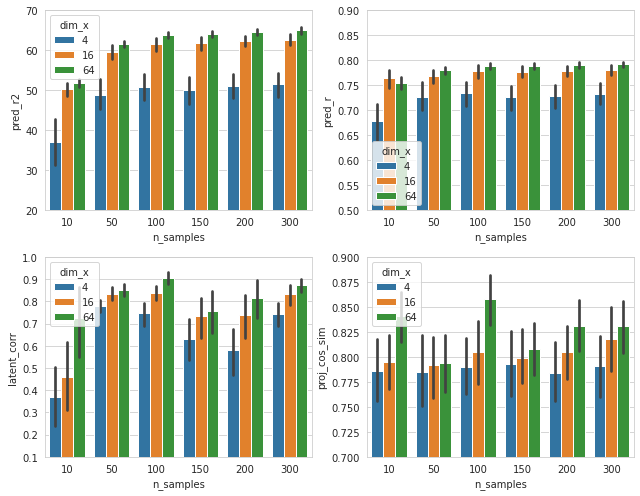

In [33]:
plt.figure(figsize=(9, 7))

plt.subplot(221)
sns.barplot(x='n_samples', y='pred_r2', data=df, hue='dim_x')
plt.ylim(20, 70)

plt.subplot(222)
sns.barplot(x='n_samples', y='pred_r', data=df, hue='dim_x')
plt.ylim(0.5, 0.9)

plt.subplot(223)
sns.barplot(x='n_samples', y='latent_corr', data=df, hue='dim_x')
plt.ylim(0.1, 1.0)

plt.subplot(224)
sns.barplot(x='n_samples', y='proj_cos_sim', data=df, hue='dim_x')
plt.ylim(0.7, 0.9)

plt.tight_layout()

### Effect of noise

In [45]:
df, args = run_pls_loop(
    n_seeds=30,
    equal_dims=True,
    sample_sizes=[100, 1000, 100000],
    dims_x=[4],
    three_d=False,
    orthogonal=False,
    normal=True,
    sigmas=np.linspace(0.0, 2.0, 41)[::-1],
)

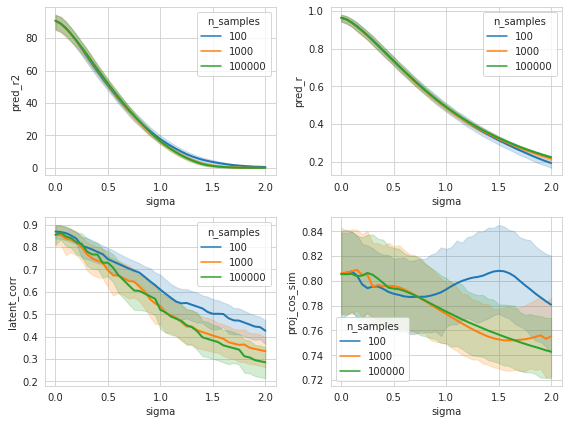

In [46]:
plt.figure(figsize=(8, 6))

palette = sns.color_palette(palette=None, n_colors=3)

plt.subplot(221)
sns.lineplot(x='sigma', y='pred_r2', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(222)
sns.lineplot(x='sigma', y='pred_r', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(223)
sns.lineplot(x='sigma', y='latent_corr', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(224)
sns.lineplot(x='sigma', y='proj_cos_sim', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)

plt.tight_layout()
plt.show()

## 3D PLS

In [47]:
df, args = run_pls_loop(
    n_seeds=30,
    equal_dims=True,
    sample_sizes=int(1e2),
    dims_x=list(np.arange(3, 71, 1).astype(int)),
    three_d=True,
    orthogonal=[False, True],
    normal=True,
    sigmas=[0.0, 0.25, 0.5],
)

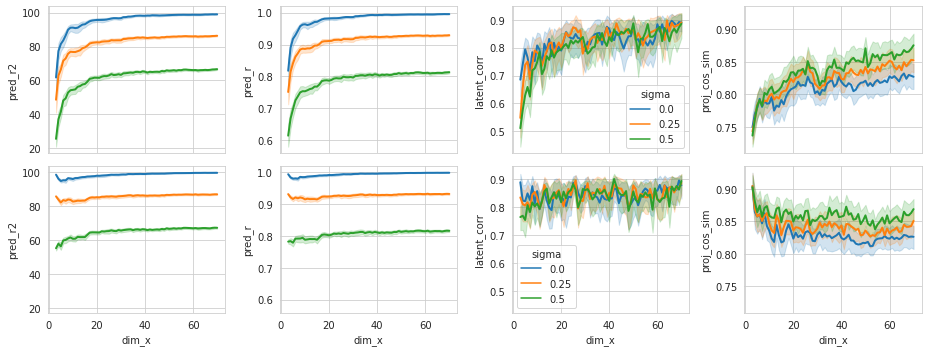

In [48]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 4, figsize=(13, 5), sharex='all', sharey='col')
palette = sns.color_palette(palette=None, n_colors=3)

for i in range(2):
    selected_df = df.loc[df.orthogonal == i]

    sns.lineplot(x='dim_x', y='pred_r2', data=selected_df, hue='sigma', style='sigma',
                 legend=False, dashes=False, lw=2, palette=palette, ax=axes[i, 0])
    sns.lineplot(x='dim_x', y='pred_r', data=selected_df, hue='sigma', style='sigma',
                 legend=False, dashes=False, lw=2, palette=palette, ax=axes[i, 1])
    sns.lineplot(x='dim_x', y='latent_corr', data=selected_df, hue='sigma', style='sigma',
                 legend=True, dashes=False, lw=2, palette=palette, ax=axes[i, 2])
    sns.lineplot(x='dim_x', y='proj_cos_sim', data=selected_df, hue='sigma', style='sigma',
                 legend=False, dashes=False, lw=2, palette=palette, ax=axes[i, 3])

plt.tight_layout()
plt.show()

### Effect of num samples

In [53]:
df, args = run_pls_loop(
    sample_sizes=[10, 50, 100, 150, 200, 300],
    equal_dims=True,
    dims_x=[4, 16, 64],
    three_d=True,
    orthogonal=False,
    normal=True,
    sigmas=0.5,
    n_seeds=30,
)

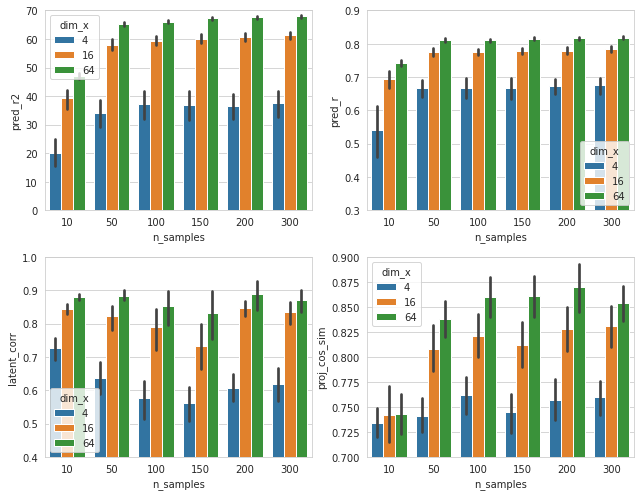

In [54]:
plt.figure(figsize=(9, 7))

plt.subplot(221)
sns.barplot(x='n_samples', y='pred_r2', data=df, hue='dim_x')
plt.ylim(0, 70)

plt.subplot(222)
sns.barplot(x='n_samples', y='pred_r', data=df, hue='dim_x')
plt.ylim(0.3, 0.9)

plt.subplot(223)
sns.barplot(x='n_samples', y='latent_corr', data=df, hue='dim_x')
plt.ylim(0.4, 1.0)

plt.subplot(224)
sns.barplot(x='n_samples', y='proj_cos_sim', data=df, hue='dim_x')
plt.ylim(0.7, 0.9)

plt.tight_layout()

### Effect of noise

In [51]:
df, args = run_pls_loop(
    n_seeds=30,
    equal_dims=True,
    sample_sizes=[100, 1000, 100000],
    dims_x=[4],
    three_d=True,
    orthogonal=False,
    normal=True,
    sigmas=np.linspace(0.0, 2.0, 41)[::-1],
)

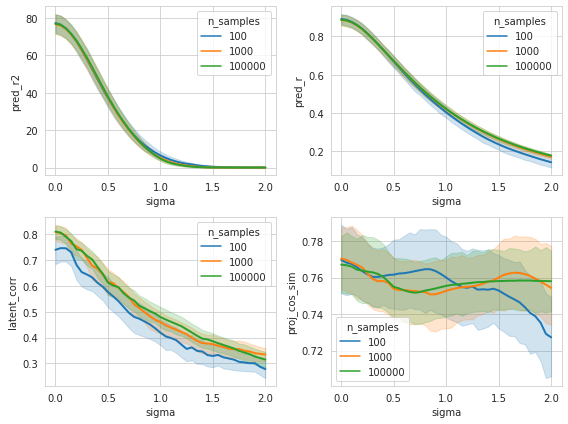

In [52]:
plt.figure(figsize=(8, 6))

palette = sns.color_palette(palette=None, n_colors=3)

plt.subplot(221)
sns.lineplot(x='sigma', y='pred_r2', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(222)
sns.lineplot(x='sigma', y='pred_r', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(223)
sns.lineplot(x='sigma', y='latent_corr', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(224)
sns.lineplot(x='sigma', y='proj_cos_sim', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)

plt.tight_layout()
plt.show()

## CCA

In [73]:
import rcca

sim = create_cca_simulation(
    num_expts=10,
    min_num_cells=16,
    max_num_cells=128,
    n_samples=int(1e2),
    sigma=0.1,
    seed=42,)
cca = rcca.CCA(kernelcca=True, ktype='linear', reg=0.1, numCC=2)
cca.train(sim['x_train']);

Training CCA, kernel = linear, regularization = 0.1000, 2 components


In [74]:
results = visualize_cca_results(cca, sim, verbose=True)
results

{'latent_corr': 0.979, 'proj_cos_sim': 0.977, 'pred_r': 0.977}

In [78]:
cca.comps[7].shape

(100, 2)

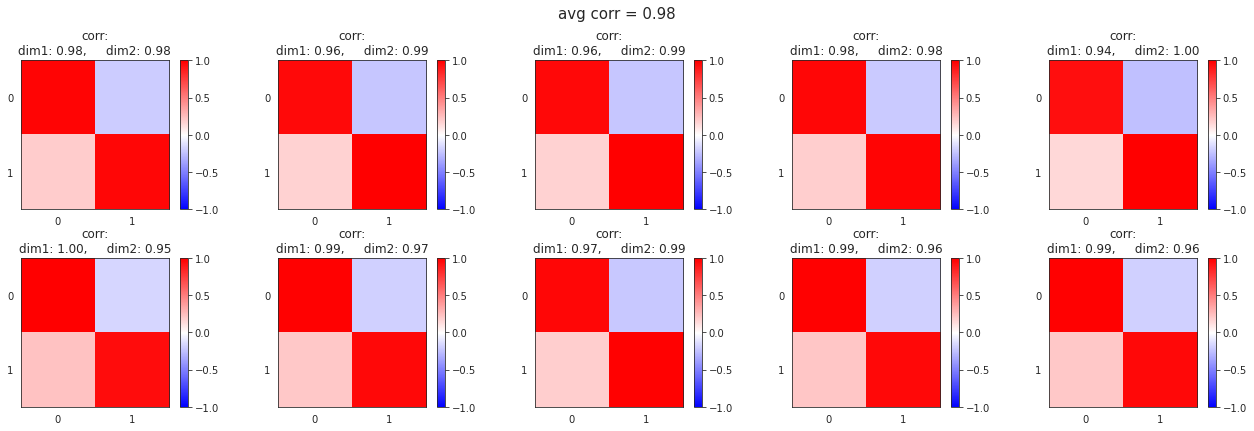

In [8]:
plt.figure(figsize=(18, 6))

corrs_all = []
for expt_id in range(10):
    cos_sim = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            cos_sim[i, j] = cos_similarity(sim['proj_mats'][expt_id][:, i], cca.ws[expt_id][:, j])
    _corrs = np.max(np.abs(cos_sim), axis=0)
    corrs_all.append(np.mean(_corrs))

    plt.subplot(2, 5, expt_id+1)
    plt.imshow(cos_sim, cmap='bwr', vmin=-1, vmax=1)
    plt.xticks(range(2))
    plt.yticks(range(2))
    plt.colorbar()
    msg = 'corr:\ndim1: {:.2f},     dim2: {:.2f}'
    msg = msg.format(*_corrs)
    plt.title(msg)

plt.suptitle('avg corr = {:.2f}'.format(np.mean(corrs_all)), fontsize=15)
plt.tight_layout()
plt.show()

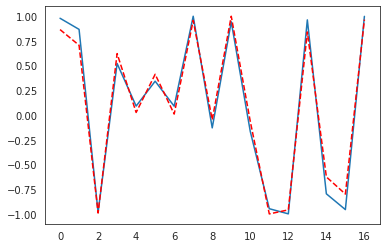

In [9]:
expt_id = 5
a = sim['proj_mats'][expt_id]
b = cca.ws[expt_id]

plt.plot(normalize(a)[:, 0])
plt.plot(normalize(b)[:, 0], 'r--')

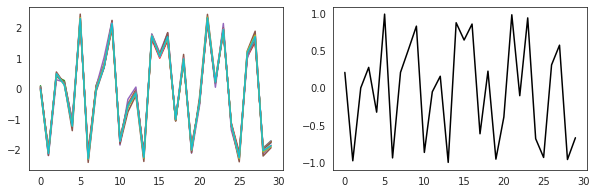

In [10]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
for c in cca.comps:
    plt.plot(c[:30, 0])

plt.subplot(122)
plt.plot(sim['z_train'][:30, 0], c='k')

## LOOP

In [11]:
df, args = run_cca_loop(
    n_seeds=30,
    reg=0.1,
    sample_sizes=[100],
    sigmas=0.1,
    normal=True,
    three_d=False,
    num_expts=10,
    min_ncs=[2, 4, 8, 16, 32, 64],
    max_ncs=[4, 8, 16, 32, 64, 256, 1024],
)

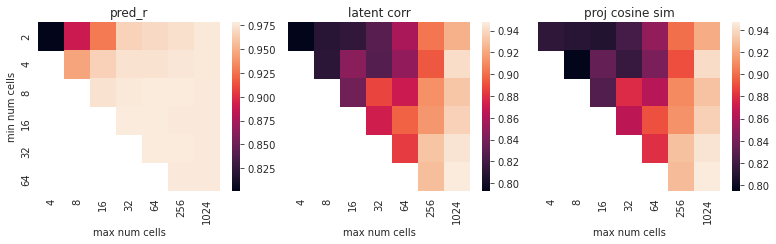

In [12]:
pred_r = np.zeros((len(args['min_ncs']), len(args['max_ncs'])))
latent_corr = np.zeros((len(args['min_ncs']), len(args['max_ncs'])))
proj_cos_sim = np.zeros((len(args['min_ncs']), len(args['max_ncs'])))

for i, min_nc in enumerate(args['min_ncs']):
    for j, max_nc in enumerate(args['max_ncs']):
        selected_df = df.loc[(df.min_nc == min_nc) & (df.max_nc == max_nc)]
        pred_r[i, j] = selected_df.pred_r.mean()
        latent_corr[i, j] = selected_df.latent_corr.mean()
        proj_cos_sim[i, j] = selected_df.proj_cos_sim.mean()

fig, axes = plt.subplots(1, 3, figsize=(11, 3.5), sharex='all', sharey='all')

sns.heatmap(pred_r, xticklabels=args['max_ncs'], yticklabels=args['min_ncs'], ax=axes[0])
sns.heatmap(latent_corr, xticklabels=args['max_ncs'], yticklabels=args['min_ncs'], ax=axes[1])
sns.heatmap(proj_cos_sim, xticklabels=args['max_ncs'], yticklabels=args['min_ncs'], ax=axes[2])

axes[0].set_title('pred_r')
axes[1].set_title('latent corr')
axes[2].set_title('proj cosine sim')

axes[0].set_ylabel('min num cells')
axes[0].set_xlabel('max num cells')
axes[1].set_xlabel('max num cells')
axes[2].set_xlabel('max num cells')

fig.tight_layout()
plt.show()

### Effect of noise

In [2]:
df, args = run_cca_loop(
    n_seeds=30,
    reg=0.1,
    sample_sizes=[10, 50, 100],
    sigmas=np.linspace(0.0, 2.0, 41)[::-1],
    normal=True,
    three_d=False,
    num_expts=[10],
    min_ncs=[32],
    max_ncs=[128],
)

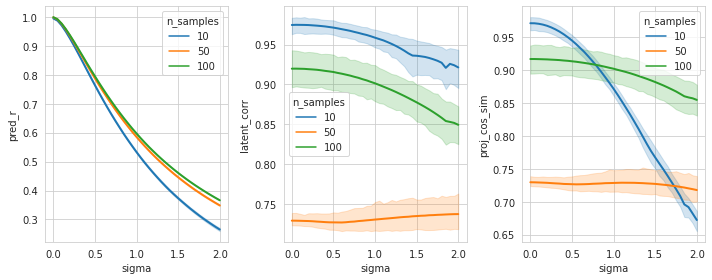

In [3]:
plt.figure(figsize=(10, 4))

palette = sns.color_palette(palette=None, n_colors=3)

plt.subplot(131)
sns.lineplot(x='sigma', y='pred_r', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(132)
sns.lineplot(x='sigma', y='latent_corr', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)
plt.subplot(133)
sns.lineplot(x='sigma', y='proj_cos_sim', data=df, hue='n_samples', style='n_samples',
             dashes=False, lw=2, palette=palette)

plt.tight_layout()
plt.show()